In [1]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from barney_functionsCNNonly import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adadelta, Adam
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
import optuna
from optuna.integration import TFKerasPruningCallback
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

/Users/jhn949/opt/anaconda3/envs/TF/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Audio Load by Barney

In [2]:
mels = np.load('mels.npz')['data']
y = np.load('mels_lables.npz',allow_pickle=True)['data']
num_classes = len(np.unique(y))
mels, TEST_images, y, TEST_y = train_test_split(mels, y, test_size=0.2, random_state=42)

In [3]:
print(mels.shape)
print(y.shape)
print(TEST_images.shape)
print(TEST_y.shape)

(1804, 128, 51)
(1804,)
(452, 128, 51)
(452,)


# CNN

# Optimising

In [19]:
def objective(trial):
    
    n_epochs = 25
    learning_rate = 0.00041
    optimiser = Adam(learning_rate=learning_rate)
    
    filters_1 = 32
    kernel_1 = 12
    strides_1 = 1
    
    activation_1 = trial.suggest_categorical("activation_1", \
                            ["relu", "tanh", "selu", "elu"])
    
    padding_1 = 'same'
    input_shape = (img_rows, img_cols, 1)
    pool_size_1 = trial.suggest_int("pool_size_1",low=2,high=4,step=1)
    
    filters_2 = 62
    kernel_2 = 10
    strides_2 = 1
    padding_2 = 'same'
    activation_2 = trial.suggest_categorical("activation_2", \
                        ["relu", "tanh", "selu", "elu"])
    pool_size_2 = trial.suggest_int("pool_size_2",low=2,high=4,step=1)
    
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.9)
    
    lin_1_n = 102
    
    batch_size = 128
    
    model = Sequential()
    model.add(Conv2D(filters=filters_1,
                     kernel_size=kernel_1,
                     strides=strides_1,
                     padding=padding_1,
                     activation=activation_1,
                     input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=pool_size_1, strides=None))
    model.add(Conv2D(filters=filters_2,
                     kernel_size=kernel_2,
                     strides=strides_2,
                     padding=padding_2,
                     activation=activation_2))
    model.add(MaxPooling2D(pool_size=pool_size_2, strides=None))
    model.add(Dropout(rate=dropout_rate))
    model.add(Flatten())
    model.add(Dense(units=lin_1_n, activation='relu'))
    model.add(Dense(units=num_classes, activation='softmax'))
    
    model.compile(loss=categorical_crossentropy,
              optimizer=optimiser,
              metrics=['categorical_accuracy'])
    
    monitor = "val_categorical_accuracy"
    
    callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=5)]
        #TFKerasPruningCallback(trial, monitor)]
    
    fitted = model.fit(X_train, y_train,
                       batch_size=batch_size,
                       epochs=n_epochs,
                       verbose=1,
                       validation_data=(X_test, y_test),
                       callbacks=callbacks)
    
    score = fitted.history[monitor][-1]
    
    return score
# changed trials to 50 from 10
# removed pruning but not callbacks

In [20]:
train_images, val_images, train_labels, val_labels = train_test_split(mels, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test, img_rows, img_cols = format_for_CNN(train_images, val_images, train_labels, val_labels)
check_class_complete_gen(train_labels, val_labels,y)

OK


In [21]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2022-06-11 00:24:58,595] A new study created in memory with name: no-name-91a3337e-896f-4d94-9f10-f607a30bb5a0


Train on 1443 samples, validate on 361 samples
Epoch 1/25
1443/1443 [==============================] - 44s 30ms/sample - loss: 0.9983 - categorical_accuracy: 0.5288 - val_loss: 0.8292 - val_categorical_accuracy: 0.6233
Epoch 2/25
1443/1443 [==============================] - 41s 28ms/sample - loss: 0.6509 - categorical_accuracy: 0.7076 - val_loss: 0.6826 - val_categorical_accuracy: 0.7091
Epoch 3/25
1443/1443 [==============================] - 45s 31ms/sample - loss: 0.5296 - categorical_accuracy: 0.7727 - val_loss: 0.5223 - val_categorical_accuracy: 0.8116
Epoch 4/25
1443/1443 [==============================] - 44s 30ms/sample - loss: 0.4102 - categorical_accuracy: 0.8240 - val_loss: 0.4799 - val_categorical_accuracy: 0.7978
Epoch 5/25
1443/1443 [==============================] - 44s 30ms/sample - loss: 0.3717 - categorical_accuracy: 0.8434 - val_loss: 0.4025 - val_categorical_accuracy: 0.8476
Epoch 6/25
1443/1443 [==============================] - 41s 29ms/sample - loss: 0.3020 - cate

[I 2022-06-11 00:42:35,560] Trial 0 finished with value: 0.9750692248344421 and parameters: {'activation_1': 'selu', 'pool_size_1': 3, 'activation_2': 'tanh', 'pool_size_2': 2, 'dropout_rate': 0.1576987588424749}. Best is trial 0 with value: 0.9750692248344421.


Train on 1443 samples, validate on 361 samples
Epoch 1/25
1443/1443 [==============================] - 59s 41ms/sample - loss: 1.1378 - categorical_accuracy: 0.4809 - val_loss: 0.9274 - val_categorical_accuracy: 0.5734
Epoch 2/25
1443/1443 [==============================] - 58s 40ms/sample - loss: 0.7369 - categorical_accuracy: 0.6667 - val_loss: 0.7416 - val_categorical_accuracy: 0.6787
Epoch 3/25
1443/1443 [==============================] - 58s 40ms/sample - loss: 0.6165 - categorical_accuracy: 0.7415 - val_loss: 0.7494 - val_categorical_accuracy: 0.7119
Epoch 4/25
1443/1443 [==============================] - 58s 40ms/sample - loss: 0.5463 - categorical_accuracy: 0.7685 - val_loss: 0.5522 - val_categorical_accuracy: 0.7922
Epoch 5/25
1443/1443 [==============================] - 58s 40ms/sample - loss: 0.4489 - categorical_accuracy: 0.7997 - val_loss: 0.4740 - val_categorical_accuracy: 0.8006
Epoch 6/25
1443/1443 [==============================] - 58s 40ms/sample - loss: 0.3723 - cate

[I 2022-06-11 01:06:38,369] Trial 1 finished with value: 0.9695290923118591 and parameters: {'activation_1': 'tanh', 'pool_size_1': 2, 'activation_2': 'selu', 'pool_size_2': 4, 'dropout_rate': 0.2507404671347976}. Best is trial 0 with value: 0.9750692248344421.


Train on 1443 samples, validate on 361 samples
Epoch 1/25
1443/1443 [==============================] - 55s 38ms/sample - loss: 1.0163 - categorical_accuracy: 0.5301 - val_loss: 0.8069 - val_categorical_accuracy: 0.6565
Epoch 2/25
1443/1443 [==============================] - 54s 37ms/sample - loss: 0.7084 - categorical_accuracy: 0.6812 - val_loss: 0.6615 - val_categorical_accuracy: 0.7091
Epoch 3/25
1443/1443 [==============================] - 54s 38ms/sample - loss: 0.5888 - categorical_accuracy: 0.7374 - val_loss: 0.5633 - val_categorical_accuracy: 0.7507
Epoch 4/25
1443/1443 [==============================] - 54s 37ms/sample - loss: 0.5053 - categorical_accuracy: 0.7859 - val_loss: 0.5132 - val_categorical_accuracy: 0.7922
Epoch 5/25
1443/1443 [==============================] - 54s 37ms/sample - loss: 0.4347 - categorical_accuracy: 0.8226 - val_loss: 0.4684 - val_categorical_accuracy: 0.7895
Epoch 6/25
1443/1443 [==============================] - 54s 37ms/sample - loss: 0.4028 - cate

[I 2022-06-11 01:29:12,311] Trial 2 finished with value: 0.9584487676620483 and parameters: {'activation_1': 'tanh', 'pool_size_1': 2, 'activation_2': 'tanh', 'pool_size_2': 4, 'dropout_rate': 0.7115522430495986}. Best is trial 0 with value: 0.9750692248344421.


Train on 1443 samples, validate on 361 samples
Epoch 1/25
1443/1443 [==============================] - 37s 26ms/sample - loss: 1.0731 - categorical_accuracy: 0.5073 - val_loss: 0.8413 - val_categorical_accuracy: 0.6454
Epoch 2/25
1443/1443 [==============================] - 38s 27ms/sample - loss: 0.7174 - categorical_accuracy: 0.6840 - val_loss: 0.6438 - val_categorical_accuracy: 0.7368
Epoch 3/25
1443/1443 [==============================] - 36s 25ms/sample - loss: 0.6205 - categorical_accuracy: 0.7374 - val_loss: 0.5941 - val_categorical_accuracy: 0.7341
Epoch 4/25
1443/1443 [==============================] - 36s 25ms/sample - loss: 0.5648 - categorical_accuracy: 0.7581 - val_loss: 0.5699 - val_categorical_accuracy: 0.7368
Epoch 5/25
1443/1443 [==============================] - 36s 25ms/sample - loss: 0.5058 - categorical_accuracy: 0.7637 - val_loss: 0.5321 - val_categorical_accuracy: 0.7452
Epoch 6/25
1443/1443 [==============================] - 36s 25ms/sample - loss: 0.4789 - cate

[I 2022-06-11 01:44:23,935] Trial 3 finished with value: 0.9639889001846313 and parameters: {'activation_1': 'elu', 'pool_size_1': 3, 'activation_2': 'selu', 'pool_size_2': 3, 'dropout_rate': 0.6525507448662851}. Best is trial 0 with value: 0.9750692248344421.


Train on 1443 samples, validate on 361 samples
Epoch 1/25
1443/1443 [==============================] - 26s 18ms/sample - loss: 1.0643 - categorical_accuracy: 0.5066 - val_loss: 0.8921 - val_categorical_accuracy: 0.6454
Epoch 2/25
1443/1443 [==============================] - 25s 18ms/sample - loss: 0.7856 - categorical_accuracy: 0.6417 - val_loss: 0.7044 - val_categorical_accuracy: 0.6870
Epoch 3/25
1443/1443 [==============================] - 25s 18ms/sample - loss: 0.6542 - categorical_accuracy: 0.7263 - val_loss: 0.6217 - val_categorical_accuracy: 0.7424
Epoch 4/25
1443/1443 [==============================] - 26s 18ms/sample - loss: 0.5842 - categorical_accuracy: 0.7498 - val_loss: 0.5846 - val_categorical_accuracy: 0.7341
Epoch 5/25
1443/1443 [==============================] - 26s 18ms/sample - loss: 0.5470 - categorical_accuracy: 0.7533 - val_loss: 0.5655 - val_categorical_accuracy: 0.7424
Epoch 6/25
1443/1443 [==============================] - 26s 18ms/sample - loss: 0.4912 - cate

[I 2022-06-11 01:55:09,659] Trial 4 finished with value: 0.9362881183624268 and parameters: {'activation_1': 'elu', 'pool_size_1': 4, 'activation_2': 'relu', 'pool_size_2': 3, 'dropout_rate': 0.5504084042013336}. Best is trial 0 with value: 0.9750692248344421.


Train on 1443 samples, validate on 361 samples
Epoch 1/25
1443/1443 [==============================] - 56s 39ms/sample - loss: 1.0807 - categorical_accuracy: 0.5066 - val_loss: 0.8640 - val_categorical_accuracy: 0.6620
Epoch 2/25
1443/1443 [==============================] - 55s 38ms/sample - loss: 0.6778 - categorical_accuracy: 0.7076 - val_loss: 0.6616 - val_categorical_accuracy: 0.7396
Epoch 3/25
1443/1443 [==============================] - 55s 38ms/sample - loss: 0.5502 - categorical_accuracy: 0.7720 - val_loss: 0.5359 - val_categorical_accuracy: 0.7507
Epoch 4/25
1443/1443 [==============================] - 55s 38ms/sample - loss: 0.4581 - categorical_accuracy: 0.8087 - val_loss: 0.4781 - val_categorical_accuracy: 0.7729
Epoch 5/25
1443/1443 [==============================] - 55s 38ms/sample - loss: 0.3975 - categorical_accuracy: 0.8267 - val_loss: 0.4504 - val_categorical_accuracy: 0.7950
Epoch 6/25
1443/1443 [==============================] - 57s 40ms/sample - loss: 0.3297 - cate

[I 2022-06-11 02:18:10,088] Trial 5 finished with value: 0.9861496090888977 and parameters: {'activation_1': 'tanh', 'pool_size_1': 2, 'activation_2': 'tanh', 'pool_size_2': 3, 'dropout_rate': 0.34395485379984586}. Best is trial 5 with value: 0.9861496090888977.


Train on 1443 samples, validate on 361 samples
Epoch 1/25
1443/1443 [==============================] - 24s 17ms/sample - loss: 1.1308 - categorical_accuracy: 0.4900 - val_loss: 0.9628 - val_categorical_accuracy: 0.4709
Epoch 2/25
1443/1443 [==============================] - 24s 16ms/sample - loss: 0.8989 - categorical_accuracy: 0.5877 - val_loss: 0.7765 - val_categorical_accuracy: 0.6842
Epoch 3/25
1443/1443 [==============================] - 23s 16ms/sample - loss: 0.7832 - categorical_accuracy: 0.6521 - val_loss: 0.7477 - val_categorical_accuracy: 0.6842
Epoch 4/25
1443/1443 [==============================] - 24s 16ms/sample - loss: 0.7511 - categorical_accuracy: 0.6833 - val_loss: 0.6928 - val_categorical_accuracy: 0.7008
Epoch 5/25
1443/1443 [==============================] - 24s 16ms/sample - loss: 0.7464 - categorical_accuracy: 0.6757 - val_loss: 0.6847 - val_categorical_accuracy: 0.7285
Epoch 6/25
1443/1443 [==============================] - 24s 16ms/sample - loss: 0.7381 - cate

[I 2022-06-11 02:23:17,205] Trial 6 finished with value: 0.761772871017456 and parameters: {'activation_1': 'tanh', 'pool_size_1': 4, 'activation_2': 'elu', 'pool_size_2': 4, 'dropout_rate': 0.6952171486014562}. Best is trial 5 with value: 0.9861496090888977.


Train on 1443 samples, validate on 361 samples
Epoch 1/25
1443/1443 [==============================] - 24s 17ms/sample - loss: 1.0476 - categorical_accuracy: 0.4976 - val_loss: 0.9168 - val_categorical_accuracy: 0.5485
Epoch 2/25
1443/1443 [==============================] - 24s 16ms/sample - loss: 0.7383 - categorical_accuracy: 0.6715 - val_loss: 0.7029 - val_categorical_accuracy: 0.6981
Epoch 3/25
1443/1443 [==============================] - 24s 17ms/sample - loss: 0.6202 - categorical_accuracy: 0.7360 - val_loss: 0.6427 - val_categorical_accuracy: 0.7507
Epoch 4/25
1443/1443 [==============================] - 24s 16ms/sample - loss: 0.5652 - categorical_accuracy: 0.7561 - val_loss: 0.5780 - val_categorical_accuracy: 0.7368
Epoch 5/25
1443/1443 [==============================] - 24s 16ms/sample - loss: 0.5338 - categorical_accuracy: 0.7699 - val_loss: 0.5566 - val_categorical_accuracy: 0.7618
Epoch 6/25
1443/1443 [==============================] - 24s 17ms/sample - loss: 0.4961 - cate

[I 2022-06-11 02:33:13,307] Trial 7 finished with value: 0.8476454019546509 and parameters: {'activation_1': 'tanh', 'pool_size_1': 4, 'activation_2': 'elu', 'pool_size_2': 3, 'dropout_rate': 0.34832923364392787}. Best is trial 5 with value: 0.9861496090888977.


Train on 1443 samples, validate on 361 samples
Epoch 1/25
1443/1443 [==============================] - 33s 23ms/sample - loss: 0.9970 - categorical_accuracy: 0.5239 - val_loss: 0.9097 - val_categorical_accuracy: 0.5817
Epoch 2/25
1443/1443 [==============================] - 33s 23ms/sample - loss: 0.7334 - categorical_accuracy: 0.6875 - val_loss: 0.7090 - val_categorical_accuracy: 0.7230
Epoch 3/25
1443/1443 [==============================] - 33s 23ms/sample - loss: 0.5949 - categorical_accuracy: 0.7464 - val_loss: 0.6293 - val_categorical_accuracy: 0.7590
Epoch 4/25
1443/1443 [==============================] - 32s 22ms/sample - loss: 0.5347 - categorical_accuracy: 0.7658 - val_loss: 0.5553 - val_categorical_accuracy: 0.7645
Epoch 5/25
1443/1443 [==============================] - 33s 23ms/sample - loss: 0.4784 - categorical_accuracy: 0.8011 - val_loss: 0.5443 - val_categorical_accuracy: 0.7479
Epoch 6/25
1443/1443 [==============================] - 33s 23ms/sample - loss: 0.4782 - cate

[I 2022-06-11 02:46:53,611] Trial 8 finished with value: 0.861495852470398 and parameters: {'activation_1': 'tanh', 'pool_size_1': 3, 'activation_2': 'elu', 'pool_size_2': 3, 'dropout_rate': 0.2755578126219972}. Best is trial 5 with value: 0.9861496090888977.


Train on 1443 samples, validate on 361 samples
Epoch 1/25
1443/1443 [==============================] - 65s 45ms/sample - loss: 1.4067 - categorical_accuracy: 0.4449 - val_loss: 0.9241 - val_categorical_accuracy: 0.5928
Epoch 2/25
1443/1443 [==============================] - 65s 45ms/sample - loss: 0.7498 - categorical_accuracy: 0.6681 - val_loss: 0.7469 - val_categorical_accuracy: 0.7285
Epoch 3/25
1443/1443 [==============================] - 65s 45ms/sample - loss: 0.6053 - categorical_accuracy: 0.7477 - val_loss: 0.6434 - val_categorical_accuracy: 0.7341
Epoch 4/25
1443/1443 [==============================] - 65s 45ms/sample - loss: 0.5056 - categorical_accuracy: 0.7928 - val_loss: 0.5653 - val_categorical_accuracy: 0.7285
Epoch 5/25
1443/1443 [==============================] - 64s 45ms/sample - loss: 0.4616 - categorical_accuracy: 0.7928 - val_loss: 0.5041 - val_categorical_accuracy: 0.8089
Epoch 6/25
1443/1443 [==============================] - 65s 45ms/sample - loss: 0.3945 - cate

[I 2022-06-11 03:13:54,905] Trial 9 finished with value: 0.9418282508850098 and parameters: {'activation_1': 'selu', 'pool_size_1': 2, 'activation_2': 'tanh', 'pool_size_2': 2, 'dropout_rate': 0.7916770543562052}. Best is trial 5 with value: 0.9861496090888977.


Train on 1443 samples, validate on 361 samples
Epoch 1/25
1443/1443 [==============================] - 59s 41ms/sample - loss: 1.1418 - categorical_accuracy: 0.5010 - val_loss: 0.7815 - val_categorical_accuracy: 0.5928
Epoch 2/25
1443/1443 [==============================] - 58s 40ms/sample - loss: 0.6543 - categorical_accuracy: 0.7277 - val_loss: 0.6124 - val_categorical_accuracy: 0.7562
Epoch 3/25
1443/1443 [==============================] - 58s 41ms/sample - loss: 0.5351 - categorical_accuracy: 0.7616 - val_loss: 0.5544 - val_categorical_accuracy: 0.7618
Epoch 4/25
1443/1443 [==============================] - 59s 41ms/sample - loss: 0.4723 - categorical_accuracy: 0.7907 - val_loss: 0.5008 - val_categorical_accuracy: 0.7673
Epoch 5/25
1443/1443 [==============================] - 58s 41ms/sample - loss: 0.4300 - categorical_accuracy: 0.8170 - val_loss: 0.5033 - val_categorical_accuracy: 0.7562
Epoch 6/25
1443/1443 [==============================] - 59s 41ms/sample - loss: 0.3800 - cate

[I 2022-06-11 03:38:17,493] Trial 10 finished with value: 0.9806094169616699 and parameters: {'activation_1': 'relu', 'pool_size_1': 2, 'activation_2': 'relu', 'pool_size_2': 2, 'dropout_rate': 0.4604554691308022}. Best is trial 5 with value: 0.9861496090888977.


Train on 1443 samples, validate on 361 samples
Epoch 1/25
1443/1443 [==============================] - 60s 42ms/sample - loss: 1.2869 - categorical_accuracy: 0.3839 - val_loss: 0.9479 - val_categorical_accuracy: 0.4986
Epoch 2/25
1443/1443 [==============================] - 59s 41ms/sample - loss: 0.7358 - categorical_accuracy: 0.6708 - val_loss: 0.7448 - val_categorical_accuracy: 0.6953
Epoch 3/25
1443/1443 [==============================] - 58s 40ms/sample - loss: 0.6385 - categorical_accuracy: 0.7297 - val_loss: 0.6327 - val_categorical_accuracy: 0.6953
Epoch 4/25
1443/1443 [==============================] - 58s 40ms/sample - loss: 0.5411 - categorical_accuracy: 0.7727 - val_loss: 0.5621 - val_categorical_accuracy: 0.7673
Epoch 5/25
1443/1443 [==============================] - 59s 41ms/sample - loss: 0.4788 - categorical_accuracy: 0.7942 - val_loss: 0.4981 - val_categorical_accuracy: 0.7701
Epoch 6/25
1443/1443 [==============================] - 58s 40ms/sample - loss: 0.4335 - cate

[I 2022-06-11 04:02:46,222] Trial 11 finished with value: 0.9778393507003784 and parameters: {'activation_1': 'relu', 'pool_size_1': 2, 'activation_2': 'relu', 'pool_size_2': 2, 'dropout_rate': 0.4180974845086168}. Best is trial 5 with value: 0.9861496090888977.


Train on 1443 samples, validate on 361 samples
Epoch 1/25
1443/1443 [==============================] - 59s 41ms/sample - loss: 1.0300 - categorical_accuracy: 0.5495 - val_loss: 0.7118 - val_categorical_accuracy: 0.6898
Epoch 2/25
1443/1443 [==============================] - 58s 40ms/sample - loss: 0.5870 - categorical_accuracy: 0.7526 - val_loss: 0.5989 - val_categorical_accuracy: 0.7452
Epoch 3/25
1443/1443 [==============================] - 59s 41ms/sample - loss: 0.5035 - categorical_accuracy: 0.7796 - val_loss: 0.5213 - val_categorical_accuracy: 0.7645
Epoch 4/25
1443/1443 [==============================] - 58s 40ms/sample - loss: 0.4259 - categorical_accuracy: 0.8143 - val_loss: 0.4582 - val_categorical_accuracy: 0.8089
Epoch 5/25
1443/1443 [==============================] - 58s 40ms/sample - loss: 0.3664 - categorical_accuracy: 0.8462 - val_loss: 0.4772 - val_categorical_accuracy: 0.7812
Epoch 6/25
1443/1443 [==============================] - 58s 40ms/sample - loss: 0.3453 - cate

[I 2022-06-11 04:27:09,573] Trial 12 finished with value: 0.9778393507003784 and parameters: {'activation_1': 'relu', 'pool_size_1': 2, 'activation_2': 'relu', 'pool_size_2': 2, 'dropout_rate': 0.47672761817068415}. Best is trial 5 with value: 0.9861496090888977.


Train on 1443 samples, validate on 361 samples
Epoch 1/25
1443/1443 [==============================] - 59s 41ms/sample - loss: 1.1324 - categorical_accuracy: 0.4886 - val_loss: 0.8588 - val_categorical_accuracy: 0.5983
Epoch 2/25
1443/1443 [==============================] - 58s 40ms/sample - loss: 0.7164 - categorical_accuracy: 0.6674 - val_loss: 0.6849 - val_categorical_accuracy: 0.6898
Epoch 3/25
1443/1443 [==============================] - 60s 42ms/sample - loss: 0.5864 - categorical_accuracy: 0.7505 - val_loss: 0.6096 - val_categorical_accuracy: 0.7368
Epoch 4/25
1443/1443 [==============================] - 59s 41ms/sample - loss: 0.5126 - categorical_accuracy: 0.7831 - val_loss: 0.5460 - val_categorical_accuracy: 0.7424
Epoch 5/25
1443/1443 [==============================] - 58s 40ms/sample - loss: 0.4283 - categorical_accuracy: 0.8080 - val_loss: 0.4505 - val_categorical_accuracy: 0.8061
Epoch 6/25
1443/1443 [==============================] - 59s 41ms/sample - loss: 0.3835 - cate

[I 2022-06-11 04:51:34,648] Trial 13 finished with value: 0.9639889001846313 and parameters: {'activation_1': 'relu', 'pool_size_1': 2, 'activation_2': 'relu', 'pool_size_2': 2, 'dropout_rate': 0.5458262145108929}. Best is trial 5 with value: 0.9861496090888977.


Train on 1443 samples, validate on 361 samples
Epoch 1/25
1443/1443 [==============================] - 34s 23ms/sample - loss: 1.1895 - categorical_accuracy: 0.4518 - val_loss: 1.0262 - val_categorical_accuracy: 0.4571
Epoch 2/25
1443/1443 [==============================] - 34s 23ms/sample - loss: 0.8472 - categorical_accuracy: 0.6202 - val_loss: 0.8406 - val_categorical_accuracy: 0.6039
Epoch 3/25
1443/1443 [==============================] - 33s 23ms/sample - loss: 0.7584 - categorical_accuracy: 0.6660 - val_loss: 0.6860 - val_categorical_accuracy: 0.6981
Epoch 4/25
1443/1443 [==============================] - 33s 23ms/sample - loss: 0.6785 - categorical_accuracy: 0.7117 - val_loss: 0.6042 - val_categorical_accuracy: 0.7507
Epoch 5/25
1443/1443 [==============================] - 34s 23ms/sample - loss: 0.5984 - categorical_accuracy: 0.7505 - val_loss: 0.5814 - val_categorical_accuracy: 0.7673
Epoch 6/25
1443/1443 [==============================] - 34s 23ms/sample - loss: 0.5943 - cate

[I 2022-06-11 05:05:37,581] Trial 14 finished with value: 0.9418282508850098 and parameters: {'activation_1': 'relu', 'pool_size_1': 3, 'activation_2': 'tanh', 'pool_size_2': 3, 'dropout_rate': 0.8920982301762208}. Best is trial 5 with value: 0.9861496090888977.


Train on 1443 samples, validate on 361 samples
Epoch 1/25
1443/1443 [==============================] - 59s 41ms/sample - loss: 1.2320 - categorical_accuracy: 0.4872 - val_loss: 0.8879 - val_categorical_accuracy: 0.5402
Epoch 2/25
1443/1443 [==============================] - 58s 40ms/sample - loss: 0.7150 - categorical_accuracy: 0.6923 - val_loss: 0.6848 - val_categorical_accuracy: 0.7008
Epoch 3/25
1443/1443 [==============================] - 58s 40ms/sample - loss: 0.5851 - categorical_accuracy: 0.7491 - val_loss: 0.6098 - val_categorical_accuracy: 0.7479
Epoch 4/25
1443/1443 [==============================] - 58s 40ms/sample - loss: 0.5189 - categorical_accuracy: 0.7755 - val_loss: 0.5295 - val_categorical_accuracy: 0.7452
Epoch 5/25
1443/1443 [==============================] - 59s 41ms/sample - loss: 0.4290 - categorical_accuracy: 0.8087 - val_loss: 0.4563 - val_categorical_accuracy: 0.7812
Epoch 6/25
1443/1443 [==============================] - 58s 41ms/sample - loss: 0.3940 - cate

[I 2022-06-11 05:29:59,087] Trial 15 finished with value: 0.9778393507003784 and parameters: {'activation_1': 'relu', 'pool_size_1': 2, 'activation_2': 'relu', 'pool_size_2': 2, 'dropout_rate': 0.10190277315257071}. Best is trial 5 with value: 0.9861496090888977.


Train on 1443 samples, validate on 361 samples
Epoch 1/25
1443/1443 [==============================] - 42s 29ms/sample - loss: 0.9846 - categorical_accuracy: 0.5523 - val_loss: 0.7957 - val_categorical_accuracy: 0.6371
Epoch 2/25
1443/1443 [==============================] - 39s 27ms/sample - loss: 0.6741 - categorical_accuracy: 0.7062 - val_loss: 0.6185 - val_categorical_accuracy: 0.7618
Epoch 3/25
1443/1443 [==============================] - 40s 28ms/sample - loss: 0.5802 - categorical_accuracy: 0.7484 - val_loss: 0.5762 - val_categorical_accuracy: 0.7756
Epoch 4/25
1443/1443 [==============================] - 40s 28ms/sample - loss: 0.5078 - categorical_accuracy: 0.7872 - val_loss: 0.6000 - val_categorical_accuracy: 0.7285
Epoch 5/25
1443/1443 [==============================] - 39s 27ms/sample - loss: 0.4691 - categorical_accuracy: 0.7997 - val_loss: 0.4881 - val_categorical_accuracy: 0.7812
Epoch 6/25
1443/1443 [==============================] - 39s 27ms/sample - loss: 0.3729 - cate

[I 2022-06-11 05:46:20,762] Trial 16 finished with value: 0.9667590260505676 and parameters: {'activation_1': 'selu', 'pool_size_1': 3, 'activation_2': 'tanh', 'pool_size_2': 4, 'dropout_rate': 0.39797065488570216}. Best is trial 5 with value: 0.9861496090888977.


Train on 1443 samples, validate on 361 samples
Epoch 1/25
1443/1443 [==============================] - 61s 42ms/sample - loss: 0.9643 - categorical_accuracy: 0.5433 - val_loss: 0.6899 - val_categorical_accuracy: 0.7258
Epoch 2/25
1443/1443 [==============================] - 61s 42ms/sample - loss: 0.6078 - categorical_accuracy: 0.7325 - val_loss: 0.6738 - val_categorical_accuracy: 0.7396
Epoch 3/25
1443/1443 [==============================] - 61s 42ms/sample - loss: 0.5526 - categorical_accuracy: 0.7588 - val_loss: 0.5343 - val_categorical_accuracy: 0.7424
Epoch 4/25
1443/1443 [==============================] - 61s 42ms/sample - loss: 0.4636 - categorical_accuracy: 0.7983 - val_loss: 0.4762 - val_categorical_accuracy: 0.7590
Epoch 5/25
1443/1443 [==============================] - 60s 42ms/sample - loss: 0.4173 - categorical_accuracy: 0.8177 - val_loss: 0.5555 - val_categorical_accuracy: 0.7313
Epoch 6/25
1443/1443 [==============================] - 60s 42ms/sample - loss: 0.4145 - cate

[I 2022-06-11 06:11:33,098] Trial 17 finished with value: 0.9473684430122375 and parameters: {'activation_1': 'elu', 'pool_size_1': 2, 'activation_2': 'selu', 'pool_size_2': 3, 'dropout_rate': 0.28968990031064384}. Best is trial 5 with value: 0.9861496090888977.


Train on 1443 samples, validate on 361 samples
Epoch 1/25
1443/1443 [==============================] - 59s 41ms/sample - loss: 1.3348 - categorical_accuracy: 0.4421 - val_loss: 0.9292 - val_categorical_accuracy: 0.5568
Epoch 2/25
1443/1443 [==============================] - 58s 40ms/sample - loss: 0.7506 - categorical_accuracy: 0.6771 - val_loss: 0.7632 - val_categorical_accuracy: 0.6510
Epoch 3/25
1443/1443 [==============================] - 58s 40ms/sample - loss: 0.6123 - categorical_accuracy: 0.7325 - val_loss: 0.7081 - val_categorical_accuracy: 0.7064
Epoch 4/25
1443/1443 [==============================] - 58s 41ms/sample - loss: 0.5506 - categorical_accuracy: 0.7741 - val_loss: 0.5847 - val_categorical_accuracy: 0.7701
Epoch 5/25
1443/1443 [==============================] - 58s 40ms/sample - loss: 0.4688 - categorical_accuracy: 0.8108 - val_loss: 0.5489 - val_categorical_accuracy: 0.7618
Epoch 6/25
1443/1443 [==============================] - 58s 40ms/sample - loss: 0.4208 - cate

[I 2022-06-11 06:35:52,401] Trial 18 finished with value: 0.9584487676620483 and parameters: {'activation_1': 'tanh', 'pool_size_1': 2, 'activation_2': 'tanh', 'pool_size_2': 2, 'dropout_rate': 0.4908544740356808}. Best is trial 5 with value: 0.9861496090888977.


Train on 1443 samples, validate on 361 samples
Epoch 1/25
1443/1443 [==============================] - 34s 23ms/sample - loss: 1.0566 - categorical_accuracy: 0.5170 - val_loss: 0.8006 - val_categorical_accuracy: 0.6205
Epoch 2/25
1443/1443 [==============================] - 33s 23ms/sample - loss: 0.6946 - categorical_accuracy: 0.7006 - val_loss: 0.6742 - val_categorical_accuracy: 0.7064
Epoch 3/25
1443/1443 [==============================] - 34s 23ms/sample - loss: 0.5940 - categorical_accuracy: 0.7394 - val_loss: 0.5454 - val_categorical_accuracy: 0.7784
Epoch 4/25
1443/1443 [==============================] - 34s 23ms/sample - loss: 0.5096 - categorical_accuracy: 0.7817 - val_loss: 0.5199 - val_categorical_accuracy: 0.7784
Epoch 5/25
1443/1443 [==============================] - 33s 23ms/sample - loss: 0.4458 - categorical_accuracy: 0.8136 - val_loss: 0.4477 - val_categorical_accuracy: 0.7756
Epoch 6/25
1443/1443 [==============================] - 33s 23ms/sample - loss: 0.3825 - cate

[I 2022-06-11 06:49:54,133] Trial 19 finished with value: 0.9778393507003784 and parameters: {'activation_1': 'relu', 'pool_size_1': 3, 'activation_2': 'relu', 'pool_size_2': 3, 'dropout_rate': 0.6008624034173061}. Best is trial 5 with value: 0.9861496090888977.


Train on 1443 samples, validate on 361 samples
Epoch 1/25
1443/1443 [==============================] - 55s 38ms/sample - loss: 0.9927 - categorical_accuracy: 0.5502 - val_loss: 0.7827 - val_categorical_accuracy: 0.6427
Epoch 2/25
1443/1443 [==============================] - 54s 38ms/sample - loss: 0.6337 - categorical_accuracy: 0.7200 - val_loss: 0.6058 - val_categorical_accuracy: 0.7729
Epoch 3/25
1443/1443 [==============================] - 54s 38ms/sample - loss: 0.5226 - categorical_accuracy: 0.7672 - val_loss: 0.5515 - val_categorical_accuracy: 0.7701
Epoch 4/25
1443/1443 [==============================] - 54s 38ms/sample - loss: 0.4342 - categorical_accuracy: 0.8164 - val_loss: 0.4637 - val_categorical_accuracy: 0.8172
Epoch 5/25
1443/1443 [==============================] - 55s 38ms/sample - loss: 0.3894 - categorical_accuracy: 0.8413 - val_loss: 0.4320 - val_categorical_accuracy: 0.8255
Epoch 6/25
1443/1443 [==============================] - 54s 38ms/sample - loss: 0.3287 - cate

[I 2022-06-11 07:12:36,409] Trial 20 finished with value: 0.9667590260505676 and parameters: {'activation_1': 'tanh', 'pool_size_1': 2, 'activation_2': 'tanh', 'pool_size_2': 4, 'dropout_rate': 0.2085194183744089}. Best is trial 5 with value: 0.9861496090888977.


Train on 1443 samples, validate on 361 samples
Epoch 1/25
1443/1443 [==============================] - 59s 41ms/sample - loss: 0.9245 - categorical_accuracy: 0.5752 - val_loss: 0.6952 - val_categorical_accuracy: 0.7341
Epoch 2/25
1443/1443 [==============================] - 59s 41ms/sample - loss: 0.5753 - categorical_accuracy: 0.7554 - val_loss: 0.5733 - val_categorical_accuracy: 0.7562
Epoch 3/25
1443/1443 [==============================] - 59s 41ms/sample - loss: 0.4479 - categorical_accuracy: 0.8143 - val_loss: 0.4614 - val_categorical_accuracy: 0.7895
Epoch 4/25
1443/1443 [==============================] - 58s 40ms/sample - loss: 0.3561 - categorical_accuracy: 0.8656 - val_loss: 0.3985 - val_categorical_accuracy: 0.8033
Epoch 5/25
1443/1443 [==============================] - 59s 41ms/sample - loss: 0.2972 - categorical_accuracy: 0.8829 - val_loss: 0.3758 - val_categorical_accuracy: 0.7867
Epoch 6/25
1443/1443 [==============================] - 58s 40ms/sample - loss: 0.2396 - cate

[I 2022-06-11 07:37:01,585] Trial 21 finished with value: 0.9667590260505676 and parameters: {'activation_1': 'relu', 'pool_size_1': 2, 'activation_2': 'relu', 'pool_size_2': 2, 'dropout_rate': 0.11860760838507232}. Best is trial 5 with value: 0.9861496090888977.


Train on 1443 samples, validate on 361 samples
Epoch 1/25
1443/1443 [==============================] - 34s 23ms/sample - loss: 1.0261 - categorical_accuracy: 0.5142 - val_loss: 0.8086 - val_categorical_accuracy: 0.6260
Epoch 2/25
1443/1443 [==============================] - 33s 23ms/sample - loss: 0.7061 - categorical_accuracy: 0.7020 - val_loss: 0.6918 - val_categorical_accuracy: 0.7008
Epoch 3/25
1443/1443 [==============================] - 33s 23ms/sample - loss: 0.5998 - categorical_accuracy: 0.7408 - val_loss: 0.5609 - val_categorical_accuracy: 0.7812
Epoch 4/25
1443/1443 [==============================] - 34s 23ms/sample - loss: 0.5076 - categorical_accuracy: 0.7748 - val_loss: 0.5048 - val_categorical_accuracy: 0.7784
Epoch 5/25
1443/1443 [==============================] - 34s 23ms/sample - loss: 0.4546 - categorical_accuracy: 0.8025 - val_loss: 0.4498 - val_categorical_accuracy: 0.7867
Epoch 6/25
1443/1443 [==============================] - 33s 23ms/sample - loss: 0.3921 - cate

[I 2022-06-11 07:51:00,157] Trial 22 finished with value: 0.9806094169616699 and parameters: {'activation_1': 'relu', 'pool_size_1': 3, 'activation_2': 'relu', 'pool_size_2': 3, 'dropout_rate': 0.5886200655379081}. Best is trial 5 with value: 0.9861496090888977.


Train on 1443 samples, validate on 361 samples
Epoch 1/25
1443/1443 [==============================] - 25s 17ms/sample - loss: 1.0176 - categorical_accuracy: 0.5329 - val_loss: 0.8741 - val_categorical_accuracy: 0.5291
Epoch 2/25
1443/1443 [==============================] - 24s 17ms/sample - loss: 0.6608 - categorical_accuracy: 0.7027 - val_loss: 0.5904 - val_categorical_accuracy: 0.7590
Epoch 3/25
1443/1443 [==============================] - 24s 17ms/sample - loss: 0.5341 - categorical_accuracy: 0.7672 - val_loss: 0.5023 - val_categorical_accuracy: 0.8116
Epoch 4/25
1443/1443 [==============================] - 25s 17ms/sample - loss: 0.4590 - categorical_accuracy: 0.8067 - val_loss: 0.4619 - val_categorical_accuracy: 0.8089
Epoch 5/25
1443/1443 [==============================] - 25s 17ms/sample - loss: 0.4046 - categorical_accuracy: 0.8288 - val_loss: 0.4100 - val_categorical_accuracy: 0.8116
Epoch 6/25
1443/1443 [==============================] - 25s 17ms/sample - loss: 0.3537 - cate

[I 2022-06-11 08:01:20,713] Trial 23 finished with value: 0.9722991585731506 and parameters: {'activation_1': 'relu', 'pool_size_1': 4, 'activation_2': 'relu', 'pool_size_2': 3, 'dropout_rate': 0.3989973452311283}. Best is trial 5 with value: 0.9861496090888977.


Train on 1443 samples, validate on 361 samples
Epoch 1/25
1443/1443 [==============================] - 34s 23ms/sample - loss: 1.0042 - categorical_accuracy: 0.5239 - val_loss: 0.8181 - val_categorical_accuracy: 0.6177
Epoch 2/25
1443/1443 [==============================] - 33s 23ms/sample - loss: 0.6855 - categorical_accuracy: 0.7034 - val_loss: 0.6309 - val_categorical_accuracy: 0.7396
Epoch 3/25
1443/1443 [==============================] - 33s 23ms/sample - loss: 0.5477 - categorical_accuracy: 0.7699 - val_loss: 0.5548 - val_categorical_accuracy: 0.7341
Epoch 4/25
1443/1443 [==============================] - 34s 23ms/sample - loss: 0.4744 - categorical_accuracy: 0.7928 - val_loss: 0.4723 - val_categorical_accuracy: 0.7867
Epoch 5/25
1443/1443 [==============================] - 34s 23ms/sample - loss: 0.4126 - categorical_accuracy: 0.8184 - val_loss: 0.4369 - val_categorical_accuracy: 0.8089
Epoch 6/25
1443/1443 [==============================] - 34s 23ms/sample - loss: 0.3914 - cate

[I 2022-06-11 08:15:22,397] Trial 24 finished with value: 0.9695290923118591 and parameters: {'activation_1': 'relu', 'pool_size_1': 3, 'activation_2': 'relu', 'pool_size_2': 3, 'dropout_rate': 0.33743575907536705}. Best is trial 5 with value: 0.9861496090888977.


Train on 1443 samples, validate on 361 samples
Epoch 1/25
1443/1443 [==============================] - 34s 23ms/sample - loss: 1.0968 - categorical_accuracy: 0.4906 - val_loss: 0.8723 - val_categorical_accuracy: 0.5983
Epoch 2/25
1443/1443 [==============================] - 33s 23ms/sample - loss: 0.7149 - categorical_accuracy: 0.6881 - val_loss: 0.6323 - val_categorical_accuracy: 0.7175
Epoch 3/25
1443/1443 [==============================] - 33s 23ms/sample - loss: 0.5850 - categorical_accuracy: 0.7561 - val_loss: 0.5511 - val_categorical_accuracy: 0.7812
Epoch 4/25
1443/1443 [==============================] - 34s 23ms/sample - loss: 0.5282 - categorical_accuracy: 0.7692 - val_loss: 0.5171 - val_categorical_accuracy: 0.7895
Epoch 5/25
1443/1443 [==============================] - 33s 23ms/sample - loss: 0.4576 - categorical_accuracy: 0.8060 - val_loss: 0.4602 - val_categorical_accuracy: 0.7950
Epoch 6/25
1443/1443 [==============================] - 33s 23ms/sample - loss: 0.4208 - cate

[I 2022-06-11 08:29:22,906] Trial 25 finished with value: 0.9806094169616699 and parameters: {'activation_1': 'relu', 'pool_size_1': 3, 'activation_2': 'relu', 'pool_size_2': 3, 'dropout_rate': 0.4644445865120948}. Best is trial 5 with value: 0.9861496090888977.


Train on 1443 samples, validate on 361 samples
Epoch 1/25
1443/1443 [==============================] - 38s 26ms/sample - loss: 1.1445 - categorical_accuracy: 0.4802 - val_loss: 0.8589 - val_categorical_accuracy: 0.6260
Epoch 2/25
1443/1443 [==============================] - 38s 26ms/sample - loss: 0.7677 - categorical_accuracy: 0.6549 - val_loss: 0.7018 - val_categorical_accuracy: 0.7147
Epoch 3/25
1443/1443 [==============================] - 36s 25ms/sample - loss: 0.6586 - categorical_accuracy: 0.7173 - val_loss: 0.6096 - val_categorical_accuracy: 0.7479
Epoch 4/25
1443/1443 [==============================] - 37s 25ms/sample - loss: 0.5801 - categorical_accuracy: 0.7477 - val_loss: 0.5579 - val_categorical_accuracy: 0.7701
Epoch 5/25
1443/1443 [==============================] - 37s 25ms/sample - loss: 0.5281 - categorical_accuracy: 0.7630 - val_loss: 0.6037 - val_categorical_accuracy: 0.7396
Epoch 6/25
1443/1443 [==============================] - 36s 25ms/sample - loss: 0.5163 - cate

[I 2022-06-11 08:44:38,253] Trial 26 finished with value: 0.9252077341079712 and parameters: {'activation_1': 'elu', 'pool_size_1': 3, 'activation_2': 'selu', 'pool_size_2': 3, 'dropout_rate': 0.5709784997023705}. Best is trial 5 with value: 0.9861496090888977.


Train on 1443 samples, validate on 361 samples
Epoch 1/25
1443/1443 [==============================] - 62s 43ms/sample - loss: 1.0712 - categorical_accuracy: 0.5274 - val_loss: 0.7744 - val_categorical_accuracy: 0.6842
Epoch 2/25
1443/1443 [==============================] - 61s 42ms/sample - loss: 0.7403 - categorical_accuracy: 0.6909 - val_loss: 0.6528 - val_categorical_accuracy: 0.7258
Epoch 3/25
1443/1443 [==============================] - 61s 42ms/sample - loss: 0.7471 - categorical_accuracy: 0.7145 - val_loss: 0.6952 - val_categorical_accuracy: 0.7341
Epoch 4/25
1443/1443 [==============================] - 61s 42ms/sample - loss: 0.7299 - categorical_accuracy: 0.7173 - val_loss: 0.5969 - val_categorical_accuracy: 0.7285
Epoch 5/25
1443/1443 [==============================] - 61s 42ms/sample - loss: 0.7320 - categorical_accuracy: 0.7311 - val_loss: 0.6158 - val_categorical_accuracy: 0.7091
Epoch 6/25
1443/1443 [==============================] - 61s 42ms/sample - loss: 0.7001 - cate

[I 2022-06-11 08:53:47,980] Trial 27 finished with value: 0.747922420501709 and parameters: {'activation_1': 'selu', 'pool_size_1': 2, 'activation_2': 'elu', 'pool_size_2': 4, 'dropout_rate': 0.6151753273099294}. Best is trial 5 with value: 0.9861496090888977.


Train on 1443 samples, validate on 361 samples
Epoch 1/25
1443/1443 [==============================] - 25s 17ms/sample - loss: 1.1194 - categorical_accuracy: 0.4955 - val_loss: 0.9267 - val_categorical_accuracy: 0.4931
Epoch 2/25
1443/1443 [==============================] - 25s 17ms/sample - loss: 0.7394 - categorical_accuracy: 0.6500 - val_loss: 0.7120 - val_categorical_accuracy: 0.7064
Epoch 3/25
1443/1443 [==============================] - 25s 17ms/sample - loss: 0.6007 - categorical_accuracy: 0.7408 - val_loss: 0.5875 - val_categorical_accuracy: 0.7645
Epoch 4/25
1443/1443 [==============================] - 25s 17ms/sample - loss: 0.5051 - categorical_accuracy: 0.7838 - val_loss: 0.5453 - val_categorical_accuracy: 0.7812
Epoch 5/25
1443/1443 [==============================] - 25s 17ms/sample - loss: 0.4503 - categorical_accuracy: 0.7956 - val_loss: 0.4714 - val_categorical_accuracy: 0.8006
Epoch 6/25
1443/1443 [==============================] - 25s 17ms/sample - loss: 0.3914 - cate

[I 2022-06-11 09:04:09,886] Trial 28 finished with value: 0.9833794832229614 and parameters: {'activation_1': 'relu', 'pool_size_1': 4, 'activation_2': 'relu', 'pool_size_2': 3, 'dropout_rate': 0.33909362910619156}. Best is trial 5 with value: 0.9861496090888977.


Train on 1443 samples, validate on 361 samples
Epoch 1/25
1443/1443 [==============================] - 31s 22ms/sample - loss: 0.9892 - categorical_accuracy: 0.5502 - val_loss: 0.7978 - val_categorical_accuracy: 0.6482
Epoch 2/25
1443/1443 [==============================] - 31s 21ms/sample - loss: 0.7057 - categorical_accuracy: 0.6902 - val_loss: 0.7701 - val_categorical_accuracy: 0.6870
Epoch 3/25
1443/1443 [==============================] - 31s 21ms/sample - loss: 0.5785 - categorical_accuracy: 0.7561 - val_loss: 0.6295 - val_categorical_accuracy: 0.7562
Epoch 4/25
1443/1443 [==============================] - 31s 21ms/sample - loss: 0.5115 - categorical_accuracy: 0.8032 - val_loss: 0.5265 - val_categorical_accuracy: 0.7895
Epoch 5/25
1443/1443 [==============================] - 30s 21ms/sample - loss: 0.4196 - categorical_accuracy: 0.8226 - val_loss: 0.5032 - val_categorical_accuracy: 0.8144
Epoch 6/25
1443/1443 [==============================] - 30s 21ms/sample - loss: 0.3933 - cate

[I 2022-06-11 09:16:53,416] Trial 29 finished with value: 0.9695290923118591 and parameters: {'activation_1': 'selu', 'pool_size_1': 4, 'activation_2': 'tanh', 'pool_size_2': 3, 'dropout_rate': 0.3483687514724134}. Best is trial 5 with value: 0.9861496090888977.


Train on 1443 samples, validate on 361 samples
Epoch 1/25
1443/1443 [==============================] - 25s 17ms/sample - loss: 0.9781 - categorical_accuracy: 0.5426 - val_loss: 0.8796 - val_categorical_accuracy: 0.6039
Epoch 2/25
1443/1443 [==============================] - 24s 16ms/sample - loss: 0.7322 - categorical_accuracy: 0.6750 - val_loss: 0.7721 - val_categorical_accuracy: 0.6565
Epoch 3/25
1443/1443 [==============================] - 24s 17ms/sample - loss: 0.6197 - categorical_accuracy: 0.7374 - val_loss: 0.7087 - val_categorical_accuracy: 0.6759
Epoch 4/25
1443/1443 [==============================] - 24s 17ms/sample - loss: 0.5317 - categorical_accuracy: 0.7810 - val_loss: 0.5718 - val_categorical_accuracy: 0.7784
Epoch 5/25
1443/1443 [==============================] - 24s 17ms/sample - loss: 0.4815 - categorical_accuracy: 0.7990 - val_loss: 0.4964 - val_categorical_accuracy: 0.7895
Epoch 6/25
1443/1443 [==============================] - 24s 17ms/sample - loss: 0.4331 - cate

[I 2022-06-11 09:26:51,456] Trial 30 finished with value: 0.9612188339233398 and parameters: {'activation_1': 'tanh', 'pool_size_1': 4, 'activation_2': 'tanh', 'pool_size_2': 3, 'dropout_rate': 0.19051879748089456}. Best is trial 5 with value: 0.9861496090888977.


Train on 1443 samples, validate on 361 samples
Epoch 1/25
1443/1443 [==============================] - 34s 23ms/sample - loss: 1.0508 - categorical_accuracy: 0.5142 - val_loss: 0.8108 - val_categorical_accuracy: 0.5983
Epoch 2/25
1443/1443 [==============================] - 34s 23ms/sample - loss: 0.6615 - categorical_accuracy: 0.7131 - val_loss: 0.5850 - val_categorical_accuracy: 0.7701
Epoch 3/25
1443/1443 [==============================] - 33s 23ms/sample - loss: 0.5586 - categorical_accuracy: 0.7623 - val_loss: 0.5429 - val_categorical_accuracy: 0.7673
Epoch 4/25
1443/1443 [==============================] - 33s 23ms/sample - loss: 0.4934 - categorical_accuracy: 0.7845 - val_loss: 0.4900 - val_categorical_accuracy: 0.7839
Epoch 5/25
1443/1443 [==============================] - 34s 23ms/sample - loss: 0.4301 - categorical_accuracy: 0.8108 - val_loss: 0.4762 - val_categorical_accuracy: 0.7950
Epoch 6/25
1443/1443 [==============================] - 35s 25ms/sample - loss: 0.4101 - cate

[I 2022-06-11 09:40:53,789] Trial 31 finished with value: 0.9750692248344421 and parameters: {'activation_1': 'relu', 'pool_size_1': 3, 'activation_2': 'relu', 'pool_size_2': 3, 'dropout_rate': 0.45160664649663157}. Best is trial 5 with value: 0.9861496090888977.


Train on 1443 samples, validate on 361 samples
Epoch 1/25
1443/1443 [==============================] - 34s 23ms/sample - loss: 1.0812 - categorical_accuracy: 0.5253 - val_loss: 0.8843 - val_categorical_accuracy: 0.6371
Epoch 2/25
1443/1443 [==============================] - 33s 23ms/sample - loss: 0.7252 - categorical_accuracy: 0.6937 - val_loss: 0.6473 - val_categorical_accuracy: 0.7479
Epoch 3/25
1443/1443 [==============================] - 34s 23ms/sample - loss: 0.5865 - categorical_accuracy: 0.7450 - val_loss: 0.5788 - val_categorical_accuracy: 0.7784
Epoch 4/25
1443/1443 [==============================] - 33s 23ms/sample - loss: 0.5275 - categorical_accuracy: 0.7775 - val_loss: 0.5380 - val_categorical_accuracy: 0.7812
Epoch 5/25
1443/1443 [==============================] - 33s 23ms/sample - loss: 0.4699 - categorical_accuracy: 0.8046 - val_loss: 0.5368 - val_categorical_accuracy: 0.7479
Epoch 6/25
1443/1443 [==============================] - 34s 23ms/sample - loss: 0.4401 - cate

[I 2022-06-11 09:54:56,841] Trial 32 finished with value: 0.9556786417961121 and parameters: {'activation_1': 'relu', 'pool_size_1': 3, 'activation_2': 'relu', 'pool_size_2': 3, 'dropout_rate': 0.5120509289684577}. Best is trial 5 with value: 0.9861496090888977.


Train on 1443 samples, validate on 361 samples
Epoch 1/25
1443/1443 [==============================] - 34s 23ms/sample - loss: 1.0120 - categorical_accuracy: 0.5211 - val_loss: 0.8199 - val_categorical_accuracy: 0.6593
Epoch 2/25
1443/1443 [==============================] - 33s 23ms/sample - loss: 0.6916 - categorical_accuracy: 0.7179 - val_loss: 0.6237 - val_categorical_accuracy: 0.7285
Epoch 3/25
1443/1443 [==============================] - 33s 23ms/sample - loss: 0.5698 - categorical_accuracy: 0.7547 - val_loss: 0.5816 - val_categorical_accuracy: 0.7368
Epoch 4/25
1443/1443 [==============================] - 33s 23ms/sample - loss: 0.5266 - categorical_accuracy: 0.7713 - val_loss: 0.5395 - val_categorical_accuracy: 0.7479
Epoch 5/25
1443/1443 [==============================] - 33s 23ms/sample - loss: 0.4641 - categorical_accuracy: 0.7990 - val_loss: 0.5236 - val_categorical_accuracy: 0.7507
Epoch 6/25
1443/1443 [==============================] - 33s 23ms/sample - loss: 0.4098 - cate

[I 2022-06-11 10:08:54,940] Trial 33 finished with value: 0.9806094169616699 and parameters: {'activation_1': 'relu', 'pool_size_1': 3, 'activation_2': 'relu', 'pool_size_2': 3, 'dropout_rate': 0.3140981269124934}. Best is trial 5 with value: 0.9861496090888977.


Train on 1443 samples, validate on 361 samples
Epoch 1/25
1443/1443 [==============================] - 25s 18ms/sample - loss: 1.0962 - categorical_accuracy: 0.5274 - val_loss: 0.9444 - val_categorical_accuracy: 0.4571
Epoch 2/25
1443/1443 [==============================] - 24s 17ms/sample - loss: 0.7491 - categorical_accuracy: 0.6681 - val_loss: 0.7474 - val_categorical_accuracy: 0.7091
Epoch 3/25
1443/1443 [==============================] - 24s 17ms/sample - loss: 0.6269 - categorical_accuracy: 0.7270 - val_loss: 0.6538 - val_categorical_accuracy: 0.7313
Epoch 4/25
1443/1443 [==============================] - 25s 17ms/sample - loss: 0.5496 - categorical_accuracy: 0.7623 - val_loss: 0.5572 - val_categorical_accuracy: 0.7729
Epoch 5/25
1443/1443 [==============================] - 24s 17ms/sample - loss: 0.4904 - categorical_accuracy: 0.7963 - val_loss: 0.5024 - val_categorical_accuracy: 0.7562
Epoch 6/25
1443/1443 [==============================] - 25s 17ms/sample - loss: 0.4075 - cate

[I 2022-06-11 10:19:13,720] Trial 34 finished with value: 0.9806094169616699 and parameters: {'activation_1': 'relu', 'pool_size_1': 4, 'activation_2': 'relu', 'pool_size_2': 3, 'dropout_rate': 0.2325854778137944}. Best is trial 5 with value: 0.9861496090888977.


Train on 1443 samples, validate on 361 samples
Epoch 1/25
1443/1443 [==============================] - 26s 18ms/sample - loss: 0.9281 - categorical_accuracy: 0.5939 - val_loss: 0.7795 - val_categorical_accuracy: 0.6620
Epoch 2/25
1443/1443 [==============================] - 25s 17ms/sample - loss: 0.6734 - categorical_accuracy: 0.7152 - val_loss: 0.6639 - val_categorical_accuracy: 0.7285
Epoch 3/25
1443/1443 [==============================] - 25s 17ms/sample - loss: 0.5583 - categorical_accuracy: 0.7561 - val_loss: 0.6514 - val_categorical_accuracy: 0.7064
Epoch 4/25
1443/1443 [==============================] - 25s 17ms/sample - loss: 0.5294 - categorical_accuracy: 0.7616 - val_loss: 0.6463 - val_categorical_accuracy: 0.7064
Epoch 5/25
1443/1443 [==============================] - 25s 17ms/sample - loss: 0.4558 - categorical_accuracy: 0.8233 - val_loss: 0.5355 - val_categorical_accuracy: 0.7839
Epoch 6/25
1443/1443 [==============================] - 25s 17ms/sample - loss: 0.3856 - cate

[I 2022-06-11 10:29:35,904] Trial 35 finished with value: 0.9806094169616699 and parameters: {'activation_1': 'tanh', 'pool_size_1': 4, 'activation_2': 'selu', 'pool_size_2': 3, 'dropout_rate': 0.23084555166024193}. Best is trial 5 with value: 0.9861496090888977.


Train on 1443 samples, validate on 361 samples
Epoch 1/25
1443/1443 [==============================] - 26s 18ms/sample - loss: 1.0198 - categorical_accuracy: 0.5398 - val_loss: 0.8916 - val_categorical_accuracy: 0.5956
Epoch 2/25
1443/1443 [==============================] - 26s 18ms/sample - loss: 0.7173 - categorical_accuracy: 0.6861 - val_loss: 0.7080 - val_categorical_accuracy: 0.6787
Epoch 3/25
1443/1443 [==============================] - 25s 17ms/sample - loss: 0.5880 - categorical_accuracy: 0.7498 - val_loss: 0.6236 - val_categorical_accuracy: 0.7341
Epoch 4/25
1443/1443 [==============================] - 25s 17ms/sample - loss: 0.5216 - categorical_accuracy: 0.7852 - val_loss: 0.5667 - val_categorical_accuracy: 0.7839
Epoch 5/25
1443/1443 [==============================] - 25s 17ms/sample - loss: 0.4656 - categorical_accuracy: 0.8087 - val_loss: 0.4983 - val_categorical_accuracy: 0.7812
Epoch 6/25
1443/1443 [==============================] - 25s 17ms/sample - loss: 0.4055 - cate

[I 2022-06-11 10:39:54,079] Trial 36 finished with value: 0.9833794832229614 and parameters: {'activation_1': 'tanh', 'pool_size_1': 4, 'activation_2': 'selu', 'pool_size_2': 4, 'dropout_rate': 0.2992233401553879}. Best is trial 5 with value: 0.9861496090888977.


Train on 1443 samples, validate on 361 samples
Epoch 1/25
1443/1443 [==============================] - 25s 17ms/sample - loss: 1.0194 - categorical_accuracy: 0.5295 - val_loss: 0.7989 - val_categorical_accuracy: 0.6427
Epoch 2/25
1443/1443 [==============================] - 24s 17ms/sample - loss: 0.7206 - categorical_accuracy: 0.6798 - val_loss: 0.7030 - val_categorical_accuracy: 0.7119
Epoch 3/25
1443/1443 [==============================] - 24s 17ms/sample - loss: 0.6413 - categorical_accuracy: 0.7242 - val_loss: 0.6788 - val_categorical_accuracy: 0.6731
Epoch 4/25
1443/1443 [==============================] - 25s 17ms/sample - loss: 0.5338 - categorical_accuracy: 0.7588 - val_loss: 0.5687 - val_categorical_accuracy: 0.7507
Epoch 5/25
1443/1443 [==============================] - 25s 17ms/sample - loss: 0.4499 - categorical_accuracy: 0.8129 - val_loss: 0.4855 - val_categorical_accuracy: 0.7867
Epoch 6/25
1443/1443 [==============================] - 25s 17ms/sample - loss: 0.4167 - cate

[I 2022-06-11 10:50:09,900] Trial 37 finished with value: 0.9722991585731506 and parameters: {'activation_1': 'tanh', 'pool_size_1': 4, 'activation_2': 'selu', 'pool_size_2': 4, 'dropout_rate': 0.24940830948284815}. Best is trial 5 with value: 0.9861496090888977.


Train on 1443 samples, validate on 361 samples
Epoch 1/25
1443/1443 [==============================] - 25s 18ms/sample - loss: 0.9660 - categorical_accuracy: 0.5502 - val_loss: 0.8490 - val_categorical_accuracy: 0.6399
Epoch 2/25
1443/1443 [==============================] - 24s 17ms/sample - loss: 0.6710 - categorical_accuracy: 0.7034 - val_loss: 0.7321 - val_categorical_accuracy: 0.6842
Epoch 3/25
1443/1443 [==============================] - 24s 17ms/sample - loss: 0.5624 - categorical_accuracy: 0.7602 - val_loss: 0.6219 - val_categorical_accuracy: 0.7396
Epoch 4/25
1443/1443 [==============================] - 24s 17ms/sample - loss: 0.4706 - categorical_accuracy: 0.8226 - val_loss: 0.5302 - val_categorical_accuracy: 0.7590
Epoch 5/25
1443/1443 [==============================] - 25s 17ms/sample - loss: 0.4046 - categorical_accuracy: 0.8316 - val_loss: 0.4770 - val_categorical_accuracy: 0.7895
Epoch 6/25
1443/1443 [==============================] - 24s 17ms/sample - loss: 0.4002 - cate

[I 2022-06-11 11:00:24,018] Trial 38 finished with value: 0.9750692248344421 and parameters: {'activation_1': 'tanh', 'pool_size_1': 4, 'activation_2': 'selu', 'pool_size_2': 4, 'dropout_rate': 0.16135292572529872}. Best is trial 5 with value: 0.9861496090888977.


Train on 1443 samples, validate on 361 samples
Epoch 1/25
1443/1443 [==============================] - 26s 18ms/sample - loss: 0.9690 - categorical_accuracy: 0.5586 - val_loss: 0.8216 - val_categorical_accuracy: 0.6260
Epoch 2/25
1443/1443 [==============================] - 27s 19ms/sample - loss: 0.6816 - categorical_accuracy: 0.7034 - val_loss: 0.6458 - val_categorical_accuracy: 0.7341
Epoch 3/25
1443/1443 [==============================] - 28s 19ms/sample - loss: 0.5977 - categorical_accuracy: 0.7422 - val_loss: 0.6086 - val_categorical_accuracy: 0.7562
Epoch 4/25
1443/1443 [==============================] - 29s 20ms/sample - loss: 0.5206 - categorical_accuracy: 0.7727 - val_loss: 0.5195 - val_categorical_accuracy: 0.7645
Epoch 5/25
1443/1443 [==============================] - 27s 18ms/sample - loss: 0.4647 - categorical_accuracy: 0.8011 - val_loss: 0.4864 - val_categorical_accuracy: 0.7756
Epoch 6/25
1443/1443 [==============================] - 25s 17ms/sample - loss: 0.4095 - cate

[I 2022-06-11 11:10:53,217] Trial 39 finished with value: 0.9778393507003784 and parameters: {'activation_1': 'tanh', 'pool_size_1': 4, 'activation_2': 'selu', 'pool_size_2': 4, 'dropout_rate': 0.2916986743538992}. Best is trial 5 with value: 0.9861496090888977.


Train on 1443 samples, validate on 361 samples
Epoch 1/25
1443/1443 [==============================] - 25s 17ms/sample - loss: 1.0940 - categorical_accuracy: 0.4920 - val_loss: 0.8507 - val_categorical_accuracy: 0.5789
Epoch 2/25
1443/1443 [==============================] - 25s 17ms/sample - loss: 0.7575 - categorical_accuracy: 0.6861 - val_loss: 0.7998 - val_categorical_accuracy: 0.6288
Epoch 3/25
1443/1443 [==============================] - 24s 17ms/sample - loss: 0.6729 - categorical_accuracy: 0.7013 - val_loss: 0.6582 - val_categorical_accuracy: 0.7479
Epoch 4/25
1443/1443 [==============================] - 25s 17ms/sample - loss: 0.5612 - categorical_accuracy: 0.7651 - val_loss: 0.6120 - val_categorical_accuracy: 0.7507
Epoch 5/25
1443/1443 [==============================] - 25s 17ms/sample - loss: 0.5048 - categorical_accuracy: 0.8011 - val_loss: 0.5159 - val_categorical_accuracy: 0.8033
Epoch 6/25
1443/1443 [==============================] - 25s 17ms/sample - loss: 0.4430 - cate

[I 2022-06-11 11:21:08,333] Trial 40 finished with value: 0.9778393507003784 and parameters: {'activation_1': 'tanh', 'pool_size_1': 4, 'activation_2': 'selu', 'pool_size_2': 4, 'dropout_rate': 0.37082332906205573}. Best is trial 5 with value: 0.9861496090888977.


Train on 1443 samples, validate on 361 samples
Epoch 1/25
1443/1443 [==============================] - 25s 17ms/sample - loss: 0.9428 - categorical_accuracy: 0.5710 - val_loss: 0.8679 - val_categorical_accuracy: 0.6122
Epoch 2/25
1443/1443 [==============================] - 25s 17ms/sample - loss: 0.6613 - categorical_accuracy: 0.7263 - val_loss: 0.6740 - val_categorical_accuracy: 0.7147
Epoch 3/25
1443/1443 [==============================] - 25s 17ms/sample - loss: 0.5845 - categorical_accuracy: 0.7436 - val_loss: 0.5772 - val_categorical_accuracy: 0.7396
Epoch 4/25
1443/1443 [==============================] - 25s 17ms/sample - loss: 0.4817 - categorical_accuracy: 0.7935 - val_loss: 0.5065 - val_categorical_accuracy: 0.7784
Epoch 5/25
1443/1443 [==============================] - 25s 17ms/sample - loss: 0.4183 - categorical_accuracy: 0.8205 - val_loss: 0.4428 - val_categorical_accuracy: 0.8255
Epoch 6/25
1443/1443 [==============================] - 25s 17ms/sample - loss: 0.3653 - cate

[I 2022-06-11 11:31:27,995] Trial 41 finished with value: 0.9667590260505676 and parameters: {'activation_1': 'tanh', 'pool_size_1': 4, 'activation_2': 'selu', 'pool_size_2': 3, 'dropout_rate': 0.23431017830105932}. Best is trial 5 with value: 0.9861496090888977.


Train on 1443 samples, validate on 361 samples
Epoch 1/25
1443/1443 [==============================] - 35s 24ms/sample - loss: 1.0923 - categorical_accuracy: 0.5038 - val_loss: 0.8782 - val_categorical_accuracy: 0.6565
Epoch 2/25
1443/1443 [==============================] - 34s 24ms/sample - loss: 0.7829 - categorical_accuracy: 0.6590 - val_loss: 0.7023 - val_categorical_accuracy: 0.7064
Epoch 3/25
1443/1443 [==============================] - 34s 24ms/sample - loss: 0.7176 - categorical_accuracy: 0.7062 - val_loss: 0.6532 - val_categorical_accuracy: 0.7396
Epoch 4/25
1443/1443 [==============================] - 34s 24ms/sample - loss: 0.7164 - categorical_accuracy: 0.7186 - val_loss: 0.6311 - val_categorical_accuracy: 0.7396
Epoch 5/25
1443/1443 [==============================] - 34s 24ms/sample - loss: 0.6803 - categorical_accuracy: 0.7152 - val_loss: 0.6491 - val_categorical_accuracy: 0.7285
Epoch 6/25
1443/1443 [==============================] - 34s 24ms/sample - loss: 0.6497 - cate

[I 2022-06-11 11:42:54,457] Trial 42 finished with value: 0.7008309960365295 and parameters: {'activation_1': 'elu', 'pool_size_1': 3, 'activation_2': 'elu', 'pool_size_2': 3, 'dropout_rate': 0.6897687272543837}. Best is trial 5 with value: 0.9861496090888977.


Train on 1443 samples, validate on 361 samples
Epoch 1/25
1443/1443 [==============================] - 33s 23ms/sample - loss: 1.0183 - categorical_accuracy: 0.5482 - val_loss: 0.8050 - val_categorical_accuracy: 0.6399
Epoch 2/25
1443/1443 [==============================] - 33s 23ms/sample - loss: 0.6681 - categorical_accuracy: 0.7096 - val_loss: 0.6322 - val_categorical_accuracy: 0.7424
Epoch 3/25
1443/1443 [==============================] - 33s 23ms/sample - loss: 0.5678 - categorical_accuracy: 0.7574 - val_loss: 0.5370 - val_categorical_accuracy: 0.7867
Epoch 4/25
1443/1443 [==============================] - 33s 23ms/sample - loss: 0.4681 - categorical_accuracy: 0.8032 - val_loss: 0.4755 - val_categorical_accuracy: 0.7922
Epoch 5/25
1443/1443 [==============================] - 33s 23ms/sample - loss: 0.4301 - categorical_accuracy: 0.8136 - val_loss: 0.4541 - val_categorical_accuracy: 0.8116
Epoch 6/25
1443/1443 [==============================] - 33s 23ms/sample - loss: 0.3975 - cate

[I 2022-06-11 11:56:47,798] Trial 43 finished with value: 0.9695290923118591 and parameters: {'activation_1': 'relu', 'pool_size_1': 3, 'activation_2': 'relu', 'pool_size_2': 3, 'dropout_rate': 0.42764185355704687}. Best is trial 5 with value: 0.9861496090888977.


Train on 1443 samples, validate on 361 samples
Epoch 1/25
1443/1443 [==============================] - 59s 41ms/sample - loss: 1.1764 - categorical_accuracy: 0.4872 - val_loss: 0.8063 - val_categorical_accuracy: 0.6620
Epoch 2/25
1443/1443 [==============================] - 58s 40ms/sample - loss: 0.6759 - categorical_accuracy: 0.7069 - val_loss: 0.6334 - val_categorical_accuracy: 0.7424
Epoch 3/25
1443/1443 [==============================] - 58s 40ms/sample - loss: 0.5721 - categorical_accuracy: 0.7443 - val_loss: 0.5774 - val_categorical_accuracy: 0.7479
Epoch 4/25
1443/1443 [==============================] - 60s 42ms/sample - loss: 0.4831 - categorical_accuracy: 0.7914 - val_loss: 0.4901 - val_categorical_accuracy: 0.7812
Epoch 5/25
1443/1443 [==============================] - 58s 40ms/sample - loss: 0.4226 - categorical_accuracy: 0.8094 - val_loss: 0.6775 - val_categorical_accuracy: 0.7452
Epoch 6/25
1443/1443 [==============================] - 58s 40ms/sample - loss: 0.4499 - cate

[I 2022-06-11 12:21:18,476] Trial 44 finished with value: 0.9778393507003784 and parameters: {'activation_1': 'relu', 'pool_size_1': 2, 'activation_2': 'relu', 'pool_size_2': 2, 'dropout_rate': 0.45882950826608837}. Best is trial 5 with value: 0.9861496090888977.


Train on 1443 samples, validate on 361 samples
Epoch 1/25
1443/1443 [==============================] - 26s 18ms/sample - loss: 0.9385 - categorical_accuracy: 0.5502 - val_loss: 0.8216 - val_categorical_accuracy: 0.6593
Epoch 2/25
1443/1443 [==============================] - 25s 17ms/sample - loss: 0.6311 - categorical_accuracy: 0.7228 - val_loss: 0.6220 - val_categorical_accuracy: 0.7535
Epoch 3/25
1443/1443 [==============================] - 25s 17ms/sample - loss: 0.5190 - categorical_accuracy: 0.7782 - val_loss: 0.6065 - val_categorical_accuracy: 0.7618
Epoch 4/25
1443/1443 [==============================] - 25s 17ms/sample - loss: 0.4714 - categorical_accuracy: 0.7942 - val_loss: 0.4998 - val_categorical_accuracy: 0.7922
Epoch 5/25
1443/1443 [==============================] - 25s 17ms/sample - loss: 0.4048 - categorical_accuracy: 0.8219 - val_loss: 0.5299 - val_categorical_accuracy: 0.7673
Epoch 6/25
1443/1443 [==============================] - 25s 17ms/sample - loss: 0.4164 - cate

[I 2022-06-11 12:31:46,194] Trial 45 finished with value: 0.9639889001846313 and parameters: {'activation_1': 'tanh', 'pool_size_1': 4, 'activation_2': 'selu', 'pool_size_2': 3, 'dropout_rate': 0.17313797583515103}. Best is trial 5 with value: 0.9861496090888977.


Train on 1443 samples, validate on 361 samples
Epoch 1/25
1443/1443 [==============================] - 36s 25ms/sample - loss: 1.0443 - categorical_accuracy: 0.5066 - val_loss: 0.7885 - val_categorical_accuracy: 0.6648
Epoch 2/25
1443/1443 [==============================] - 35s 24ms/sample - loss: 0.7317 - categorical_accuracy: 0.6722 - val_loss: 0.6443 - val_categorical_accuracy: 0.7452
Epoch 3/25
1443/1443 [==============================] - 35s 24ms/sample - loss: 0.6298 - categorical_accuracy: 0.7221 - val_loss: 0.5981 - val_categorical_accuracy: 0.7645
Epoch 4/25
1443/1443 [==============================] - 35s 24ms/sample - loss: 0.5989 - categorical_accuracy: 0.7380 - val_loss: 0.5813 - val_categorical_accuracy: 0.7673
Epoch 5/25
1443/1443 [==============================] - 35s 24ms/sample - loss: 0.5516 - categorical_accuracy: 0.7609 - val_loss: 0.5383 - val_categorical_accuracy: 0.7756
Epoch 6/25
1443/1443 [==============================] - 35s 24ms/sample - loss: 0.5285 - cate

[I 2022-06-11 12:46:24,591] Trial 46 finished with value: 0.9030470848083496 and parameters: {'activation_1': 'elu', 'pool_size_1': 3, 'activation_2': 'tanh', 'pool_size_2': 3, 'dropout_rate': 0.7750081390432448}. Best is trial 5 with value: 0.9861496090888977.


Train on 1443 samples, validate on 361 samples
Epoch 1/25
1443/1443 [==============================] - 33s 23ms/sample - loss: 1.0292 - categorical_accuracy: 0.5232 - val_loss: 0.8360 - val_categorical_accuracy: 0.6399
Epoch 2/25
1443/1443 [==============================] - 31s 21ms/sample - loss: 0.7243 - categorical_accuracy: 0.6805 - val_loss: 0.7705 - val_categorical_accuracy: 0.6482
Epoch 3/25
1443/1443 [==============================] - 31s 21ms/sample - loss: 0.6234 - categorical_accuracy: 0.7394 - val_loss: 0.6261 - val_categorical_accuracy: 0.7258
Epoch 4/25
1443/1443 [==============================] - 30s 21ms/sample - loss: 0.5868 - categorical_accuracy: 0.7651 - val_loss: 0.5779 - val_categorical_accuracy: 0.7645
Epoch 5/25
1443/1443 [==============================] - 30s 21ms/sample - loss: 0.5384 - categorical_accuracy: 0.7755 - val_loss: 0.6120 - val_categorical_accuracy: 0.7230
Epoch 6/25
1443/1443 [==============================] - 31s 21ms/sample - loss: 0.5178 - cate

[I 2022-06-11 12:59:07,693] Trial 47 finished with value: 0.7977839112281799 and parameters: {'activation_1': 'selu', 'pool_size_1': 4, 'activation_2': 'elu', 'pool_size_2': 3, 'dropout_rate': 0.37464235703807386}. Best is trial 5 with value: 0.9861496090888977.


Train on 1443 samples, validate on 361 samples
Epoch 1/25
1443/1443 [==============================] - 25s 17ms/sample - loss: 1.0144 - categorical_accuracy: 0.5156 - val_loss: 0.8043 - val_categorical_accuracy: 0.6704
Epoch 2/25
1443/1443 [==============================] - 24s 17ms/sample - loss: 0.6984 - categorical_accuracy: 0.6916 - val_loss: 0.6316 - val_categorical_accuracy: 0.7479
Epoch 3/25
1443/1443 [==============================] - 26s 18ms/sample - loss: 0.5861 - categorical_accuracy: 0.7581 - val_loss: 0.5829 - val_categorical_accuracy: 0.7645
Epoch 4/25
1443/1443 [==============================] - 25s 17ms/sample - loss: 0.5191 - categorical_accuracy: 0.7803 - val_loss: 0.5616 - val_categorical_accuracy: 0.7812
Epoch 5/25
1443/1443 [==============================] - 24s 17ms/sample - loss: 0.4522 - categorical_accuracy: 0.8150 - val_loss: 0.4711 - val_categorical_accuracy: 0.8227
Epoch 6/25
1443/1443 [==============================] - 25s 17ms/sample - loss: 0.3959 - cate

[I 2022-06-11 13:09:28,308] Trial 48 finished with value: 0.9722991585731506 and parameters: {'activation_1': 'relu', 'pool_size_1': 4, 'activation_2': 'relu', 'pool_size_2': 3, 'dropout_rate': 0.2741752415755302}. Best is trial 5 with value: 0.9861496090888977.


Train on 1443 samples, validate on 361 samples
Epoch 1/25
1443/1443 [==============================] - 59s 41ms/sample - loss: 1.2414 - categorical_accuracy: 0.5017 - val_loss: 0.9398 - val_categorical_accuracy: 0.5956
Epoch 2/25
1443/1443 [==============================] - 58s 40ms/sample - loss: 0.7555 - categorical_accuracy: 0.6604 - val_loss: 0.8101 - val_categorical_accuracy: 0.6620
Epoch 3/25
1443/1443 [==============================] - 58s 40ms/sample - loss: 0.5735 - categorical_accuracy: 0.7533 - val_loss: 0.6812 - val_categorical_accuracy: 0.7008
Epoch 4/25
1443/1443 [==============================] - 58s 41ms/sample - loss: 0.4766 - categorical_accuracy: 0.8094 - val_loss: 0.5640 - val_categorical_accuracy: 0.7341
Epoch 5/25
1443/1443 [==============================] - 59s 41ms/sample - loss: 0.4097 - categorical_accuracy: 0.8136 - val_loss: 0.5066 - val_categorical_accuracy: 0.7452
Epoch 6/25
1443/1443 [==============================] - 58s 41ms/sample - loss: 0.3586 - cate

[I 2022-06-11 13:33:52,108] Trial 49 finished with value: 0.9667590260505676 and parameters: {'activation_1': 'tanh', 'pool_size_1': 2, 'activation_2': 'tanh', 'pool_size_2': 2, 'dropout_rate': 0.5224007409709506}. Best is trial 5 with value: 0.9861496090888977.


In [22]:
optimised_params = study.best_params
print(optimised_params)

{'activation_1': 'tanh', 'pool_size_1': 2, 'activation_2': 'tanh', 'pool_size_2': 3, 'dropout_rate': 0.34395485379984586}


In [23]:
def opt_model(optimised_params):
    n_epochs = 25
    learning_rate = 0.00041
    optimiser = Adam(learning_rate=learning_rate)
    # Conv 1
    filters_1 = 32
    kernel_size_1 = 12
    strides_1 = 1
    padding_1 = 'same'
    activation_1 = 'tanh'
    input_shape = (img_rows, img_cols, 1)
    # Pool 1
    pool_size_1 = 2
    # Conv 2
    filters_2 = 62
    kernel_size_2 = 10
    strides_2 = 1
    padding_2 = 'same'
    activation_2 = 'tanh'
    # Pool 2
    pool_size_2 = 3
    # Droput
    dropout_rate = 0.344
    # Lin 1
    lin_1_n = 102
    
    model = Sequential()
    model.add(Conv2D(filters=filters_1,
                     kernel_size=kernel_size_1,
                     strides=strides_1,
                     padding=padding_1,
                     activation=activation_1,
                     input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=pool_size_1, strides=None))
    model.add(Conv2D(filters=filters_2,
                     kernel_size=kernel_size_2,
                     strides=strides_2,
                     padding=padding_2,
                     activation=activation_2))
    model.add(MaxPooling2D(pool_size=pool_size_2, strides=None))
    model.add(Dropout(rate=dropout_rate))
    model.add(Flatten())
    model.add(Dense(units=lin_1_n, activation='relu'))
    model.add(Dense(units=num_classes, activation='softmax'))
    
    model.compile(loss=categorical_crossentropy,
              optimizer=optimiser,
              metrics=['categorical_accuracy'])
    
    return model

# Folding

In [26]:
n_folds = 5
kfold = KFold(n_splits=n_folds, shuffle=True)
X = mels
y = y 
# Human Optimisation...
check_class_complete(kfold,X,y)
#optimised_params['learning_rate'] = 0.0014280245429123698/2
#optimised_params['n_epochs'] = 30
n_epochs = 25
fold_loss = np.zeros((n_folds,n_epochs))
np.save('optimised_params',optimised_params)
print(optimised_params)

ALL CLASSES PRESENT
{'activation_1': 'tanh', 'pool_size_1': 2, 'activation_2': 'tanh', 'pool_size_2': 3, 'dropout_rate': 0.34395485379984586}


In [27]:
fold_no = 1
for train_index, test_index in kfold.split(X, y):
    
    print("-----------------------------------")
    print("FOLD "+str(fold_no))
    print("-----------------------------------")
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    X_train,X_test,y_train,y_test, img_rows, img_cols = format_for_CNN(X_train,X_test,y_train,y_test)
    
    model = opt_model(optimised_params)

    history = model.fit(X_train, y_train,
                        batch_size=128,
                        epochs=n_epochs,
                        verbose=1,
                        validation_data=(X_test, y_test))
    
    fold_loss[fold_no-1] = history.history['val_categorical_accuracy']
    fold_no += 1

-----------------------------------
FOLD 1
-----------------------------------
Train on 1443 samples, validate on 361 samples
Epoch 1/25
1443/1443 [==============================] - 56s 39ms/sample - loss: 1.1722 - categorical_accuracy: 0.5087 - val_loss: 0.6951 - val_categorical_accuracy: 0.6981
Epoch 2/25
1443/1443 [==============================] - 57s 39ms/sample - loss: 0.7063 - categorical_accuracy: 0.6958 - val_loss: 0.5629 - val_categorical_accuracy: 0.7618
Epoch 3/25
1443/1443 [==============================] - 56s 39ms/sample - loss: 0.5833 - categorical_accuracy: 0.7588 - val_loss: 0.4426 - val_categorical_accuracy: 0.7978
Epoch 4/25
1443/1443 [==============================] - 56s 39ms/sample - loss: 0.4752 - categorical_accuracy: 0.8060 - val_loss: 0.4338 - val_categorical_accuracy: 0.8199
Epoch 5/25
1443/1443 [==============================] - 56s 39ms/sample - loss: 0.4257 - categorical_accuracy: 0.8115 - val_loss: 0.3372 - val_categorical_accuracy: 0.8560
Epoch 6/25
144

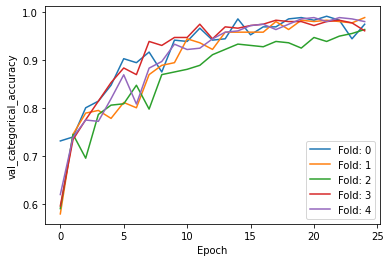

Mean val_categorical_accuracy:  0.97395


In [15]:
for i in range(n_folds):
    plt.plot(fold_loss[i], label='Fold: '+str(i))
plt.xlabel('Epoch')
plt.ylabel('val_categorical_accuracy')
plt.legend()
plt.show()
mean_acc = np.mean(fold_loss[:,-1])
print('Mean val_categorical_accuracy: ',np.around(mean_acc,5))

1st convolution layer:


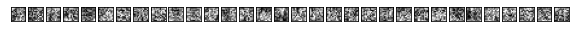

2nd convolution layer:


In [16]:
# model.layers will print a list of layer parameters/values
filters1, biases1 = model.layers[0].get_weights()
filters2, biases2 = model.layers[2].get_weights()

# normalize filter values to range 0-1 for better colormapping during plotting
def norm_filter(kernel):
    return (kernel - np.min(kernel)) / (np.max(kernel) - np.min(kernel))

n_1 = optimised_params['filters_1']
print('1st convolution layer:')
fig, axs = plt.subplots(1,n_1, figsize=(10, 6))
axs = axs.ravel()
for i in range(n_1):
    axs[i].imshow(norm_filter(filters1[:,:,0,i]), cmap=plt.cm.binary)
    axs[i].set_xticks([]); axs[i].set_yticks([]); axs[i].grid(False)
plt.show()

n_2 = optimised_params['filters_2']
print('2nd convolution layer:')
fig, axs = plt.subplots(1,n_2, figsize=(10, 6))
axs = axs.ravel()
for i in range(n_2):
    axs[i].imshow(norm_filter(filters2[:,:,0,i]), cmap=plt.cm.binary)
    axs[i].set_xticks([]); axs[i].set_yticks([]); axs[i].grid(False)

### Evaluation

In [17]:
predicted_prob = model.predict(TEST_images)
predictions = np.argmax(predicted_prob, axis=1)

In [18]:
print(predictions.shape)
print(TEST_y.shape)

(452,)
(452,)


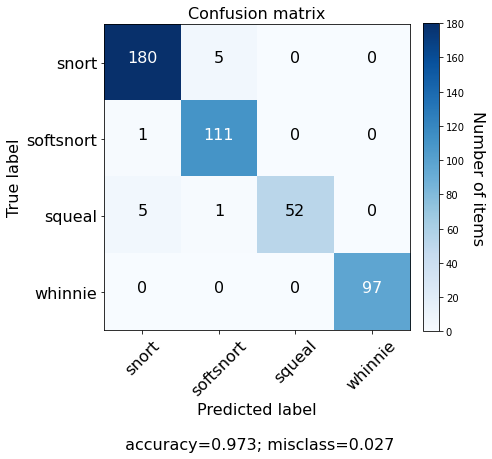

In [22]:
labels_list = np.unique(TEST_y)
onehot_v = pd.get_dummies(TEST_y)
onehot_y = onehot_v.to_numpy()
truths = np.argmax(onehot_y, axis=1)
cm = confusion_matrix(truths, predictions, labels=range(num_classes))
plot_confusion_matrix(cm,labels_list,normalize=False,savefig = 'CM_CNN_OPT')